<center>
    <h1>Assignment 2 - Question Answering with Transformers on CoQA</h1>
    <h2>Natural Language Processing</h2>
    <h3>Antonio Politano, Enrico Pittini, Riccardo Spolaor and Samuele Bortolato</h3>
    <h4>antonio.politano2@studio.unibo.it, enrico.pittini@studio.unibo.it, riccardo.spolaor@studio.unibo.it, samuele.bortolato@studio.unibo.it</h4>
</center>



---



Assignment description: see `Assignment.ipynb`

In [54]:
import json
import numpy as np
import pandas as pd

In [ ]:
# Settings for autoreloading

%load_ext autoreload
%autoreload 2

In [ ]:
# Settings for reproducibility

import random 
import torch
import os

def set_random_seed(random_seed: int = 42) -> None:
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Task 1

In [55]:
import os
import urllib.request
from tqdm import tqdm

class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def download_data(data_path, url_path, suffix):    
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
    data_path = os.path.join(data_path, f'{suffix}.json')

    if not os.path.exists(data_path):
        print(f"Downloading CoQA {suffix} data split... (it may take a while)")
        download_url(url=url_path, output_path=data_path)
        print("Download completed!")

In [56]:
# Train data
train_url = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
download_data(data_path='coqa', url_path=train_url, suffix='train')

# Test data
test_url = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"
download_data(data_path='coqa', url_path=test_url, suffix='test')  # <-- Why test? See next slides for an answer!

In [57]:
def get_dataframe(json_path: str):
    def create_history(row: pd.Series):
        history = []
        max_turn = row['question_turn_id'] - 1
        for i, (q, a) in enumerate(zip(row['questions'], row['answers'])):
            if i >= max_turn:
                break
            if a['input_text'] != 'unknown':
                history += [q['input_text'], a['input_text']]
        return history
    
    with open(json_path, 'r') as j:
        data = json.loads(j.read())['data']
    
        questions_df = pd.json_normalize(data, record_path='questions', meta=['id'], record_prefix='question_')
        answers_df = pd.json_normalize(data, record_path='answers', record_prefix='answer_')
        
        passages_df = pd.json_normalize(data, max_level=0)
        # passages_df.drop(['questions', 'answers'], axis=1, inplace=True)
        if 'additional_answers' in passages_df:
            passages_df.drop('additional_answers', axis=1, inplace=True)
    
        questions_and_answers_df = pd.concat([questions_df, answers_df], axis=1, join='inner')
    
        df = passages_df.merge(questions_and_answers_df, on='id')
        
        df['history'] = df.apply(create_history, axis=1)
        
        df.drop(['questions', 'answers'], axis=1, inplace=True)
        
        return df.reset_index(drop=True)

In [58]:
train_df = get_dataframe(os.path.join('coqa', 'train.json'))
train_df.head()

,source,id,filename,story,name,question_input_text,question_turn_id,question_bad_turn,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,answer_bad_turn,history
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,When was the Vat formally opened?,1,NaN,151,179,Formally established in 1475,It was formally established in 1475,1,NaN,[]
1,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what is the library for?,2,NaN,454,494,he Vatican Library is a research library,research,2,NaN,"[When was the Vat formally opened?, It was for..."
2,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,for what subjects?,3,NaN,457,511,Vatican Library is a research library for hist...,"history, and law",3,NaN,"[When was the Vat formally opened?, It was for..."
3,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,and?,4,NaN,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,NaN,"[When was the Vat formally opened?, It was for..."
4,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",Vatican_Library.txt,what was started in 2014?,5,NaN,769,879,"March 2014, the Vatican Library began an initi...",a project,5,NaN,"[When was the Vat formally opened?, It was for..."


In [59]:
test_df = get_dataframe(os.path.join('coqa', 'test.json'))
test_df.head()

,source,id,filename,story,name,question_input_text,question_turn_id,answer_span_start,answer_span_end,answer_span_text,answer_input_text,answer_turn_id,history
0,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...",mc160.test.41,What color was Cotton?,1,59,93,a little white kitten named Cotton,white,1,[]
1,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...",mc160.test.41,Where did she live?,2,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...",mc160.test.41,Did she live alone?,3,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...",mc160.test.41,Who did she live with?,4,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,mctest,3dr23u6we5exclen4th8uq9rb42tel,mc160.test.41,"Once upon a time, in a barn near a farm house,...",mc160.test.41,What color were her sisters?,5,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


Remove Unanswerable Questions and the respective answers

In [60]:
# Delete rows with unknown answer

train_df.drop(train_df[train_df['answer_input_text'] == 'unknown'].index, inplace=True)
train_df.reset_index(drop=True, inplace=True)

test_df.drop(test_df[test_df['answer_input_text'] == 'unknown'].index, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [61]:
print(train_df.shape)
print(test_df.shape)

(107276, 15)
(7917, 13)


In [62]:
assert train_df['question_turn_id'].equals(train_df['answer_turn_id']), \
    'Question and answer turn ids are different in the train dataset'
    
assert test_df['question_turn_id'].equals(test_df['answer_turn_id']), \
    'Question and answer turn ids are different in the test dataset'

In [63]:
def refactor_turn_columns(df: pd.DataFrame):
    df.drop('question_turn_id', axis=1, inplace=True)
    df.rename(columns = {'answer_turn_id': 'turn_id'}, inplace = True)
    
refactor_turn_columns(train_df)
refactor_turn_columns(test_df)

In [64]:
column_renames = {'answer_input_text': 'answer', 'question_input_text': 'question'}

train_df.rename(columns=column_renames, inplace=True)
test_df.rename(columns=column_renames, inplace=True)

In [65]:
# Drop bad turn columns along with other unuseful columns

train_df.drop(['question_bad_turn', 'answer_bad_turn'], axis=1, inplace=True)
train_df.drop(['source', 'name', 'filename'], axis=1, inplace=True)
test_df.drop(['source', 'name', 'filename'], axis=1, inplace=True)

In [66]:
print(f'Null values in the train dataframe: {train_df.isna().sum().sum()}.')
print(f'Null values in the test dataframe: {test_df.isna().sum().sum()}.')

Null values in the train dataframe: 0.
Null values in the test dataframe: 0.


In [67]:
train_df.head()

,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,151,179,Formally established in 1475,It was formally established in 1475,1,[]
1,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what is the library for?,454,494,he Vatican Library is a research library,research,2,"[When was the Vat formally opened?, It was for..."
2,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",for what subjects?,457,511,Vatican Library is a research library for hist...,"history, and law",3,"[When was the Vat formally opened?, It was for..."
3,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",and?,457,545,Vatican Library is a research library for hist...,"philosophy, science and theology",4,"[When was the Vat formally opened?, It was for..."
4,3zotghdk5ibi9cex97fepx7jetpso7,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,769,879,"March 2014, the Vatican Library began an initi...",a project,5,"[When was the Vat formally opened?, It was for..."


In [68]:
test_df.head()

,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color was Cotton?,59,93,a little white kitten named Cotton,white,1,[]
1,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Where did she live?,18,80,"in a barn near a farm house, there lived a lit...",in a barn,2,"[What color was Cotton?, white]"
2,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Did she live alone?,196,215,Cotton wasn't alone,no,3,"[What color was Cotton?, white, Where did she ..."
3,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",Who did she live with?,281,315,with her mommy and 5 other sisters,with her mommy and 5 sisters,4,"[What color was Cotton?, white, Where did she ..."
4,3dr23u6we5exclen4th8uq9rb42tel,"Once upon a time, in a barn near a farm house,...",What color were her sisters?,428,490,her sisters were all orange with beautiful whi...,orange and white,5,"[What color was Cotton?, white, Where did she ..."


Analysis

In [69]:
grouped_train_df = train_df.groupby(by=['id'])

In [70]:
print(f'Number of train passages: {len(grouped_train_df)}')

Number of train passages: 7193


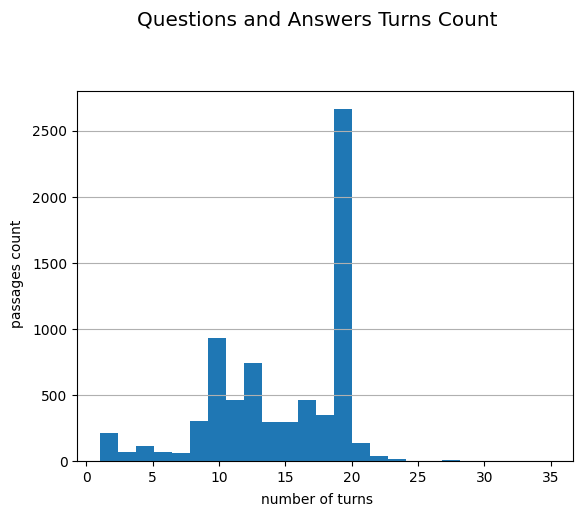

In [71]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

# drop sharex, sharey, layout & add ax=axes
grouped_train_df['turn_id'].count().hist(bins=25, ax= axes)

axes.grid(axis='x')

# set title and axis labels
plt.suptitle('Questions and Answers Turns Count', x=0.5, y=1.05, ha='center', fontsize='x-large')
fig.text(0.5, 0.02, 'number of turns', ha='center')
fig.text(0.02, 0.5, 'passages count', va='center', rotation='vertical')
plt.show()


In [72]:
def plot_passage_length_analysis(passages: pd.Series):
    """Analyse the length of the passages in the given dataset

    Parameters
    ----------
    texts : pd.Series
        The passages.
    """
    # Length of each training sentence
    train_passages_lenghts = list(passages.transform(lambda x: x[0].split(' ')).str.len())

    # Histogram of the sentences length distribution
    hist, bin_edges = np.histogram(train_passages_lenghts, bins=np.max(train_passages_lenghts) + 1, density=True) 
    # Cumulative distribution of the sentences length
    C = np.cumsum(hist)*(bin_edges[1] - bin_edges[0])

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(bin_edges[1:], hist)
    plt.title('Distribution of the passages length across the train dataset')
    plt.xlabel('Passage length')
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(bin_edges[1:], C)
    plt.title('Comulative distribution of the passages length across the train dataset')
    plt.xlabel('Passage length')
    plt.grid()
    plt.show()

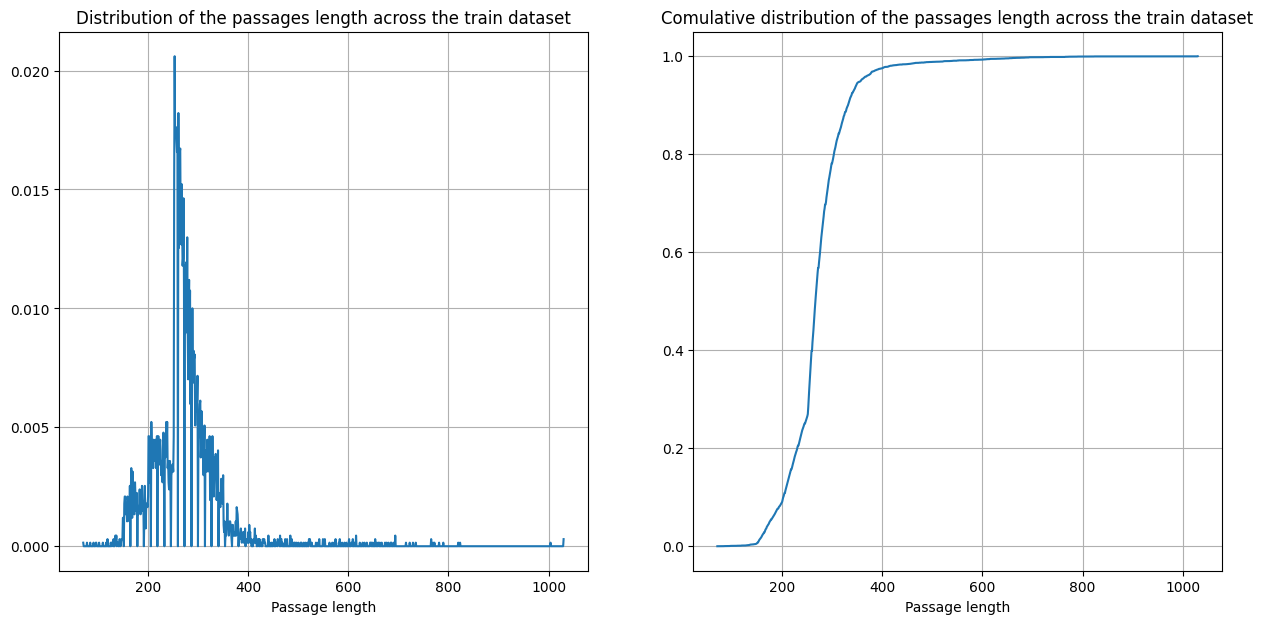

In [73]:
plot_passage_length_analysis(grouped_train_df.story.unique())

In [74]:
def plot_answer_span_text_percentile(df: pd.DataFrame):
    """Analyse the percentile of the answer span text start index with respect to the passage

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe.
    """
    
    percentiles = df['answer_span_start'] / df['story'].str.len()

    # Histogram of the sentences length distribution
    hist, bin_edges = np.histogram(percentiles.to_list(), bins=50, density=True)
    hist = hist / sum(hist)

    plt.figure(figsize=(15, 7))
    plt.plot(bin_edges[1:], hist)
    plt.title('Distribution of the  percentiles of the answer span text start index with respect to the passage')
    plt.xlabel('Percentile')
    plt.grid()
    plt.show()

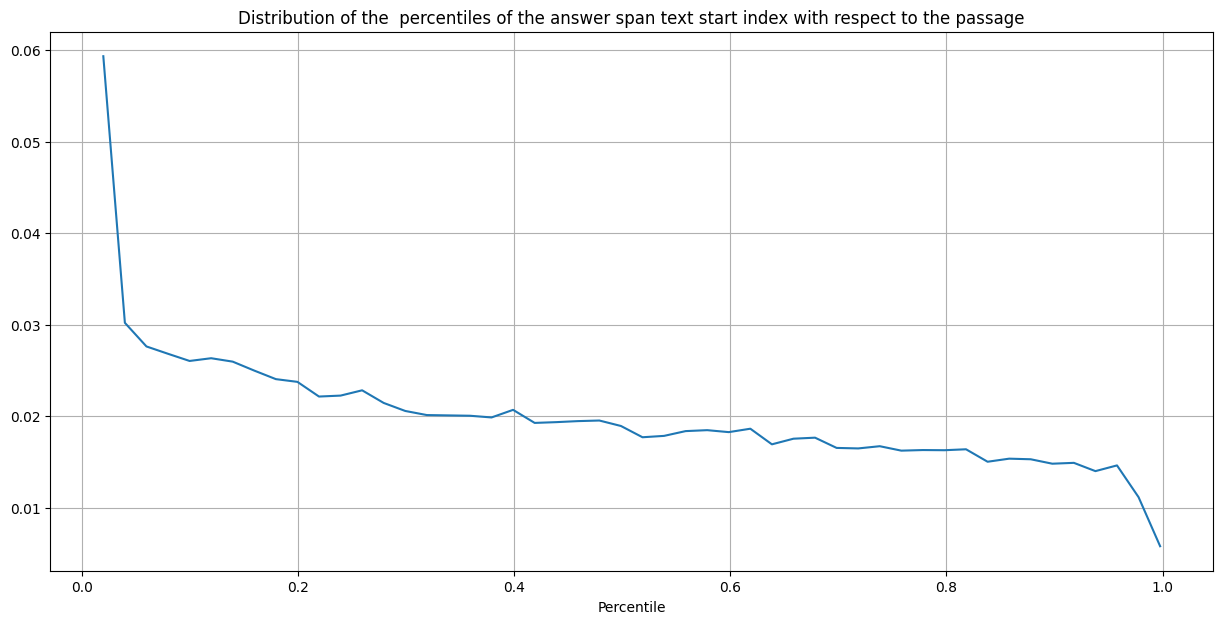

In [75]:
plot_answer_span_text_percentile(train_df)

## [Task 2] Train, Validation and Test splits

In [76]:
set_random_seed(42)

In [109]:
def shuffle_df(df: pd.DataFrame):
    df_original = df.copy()
    shuffled_ids = df_original['id'].unique()
    np.random.shuffle(shuffled_ids)

    new_df = pd.DataFrame()
    for id in shuffled_ids:
        new_df = pd.concat([new_df, df_original[df_original['id'] == id]], ignore_index=True, axis=0)
    return new_df

In [110]:
# Todo: decide whether to use them

#train_df = shuffle_df(train_df)
#train_df.head()

In [93]:
question_percentile_index = int(len(train_df) * .8)

document_id_at_percentile = train_df.iloc[question_percentile_index]['id']

In [94]:
question_percentile_index

68656

In [95]:
val_df = train_df[(train_df.index >= question_percentile_index) & (train_df['id'] != document_id_at_percentile)]
val_df_start_index = val_df.index[0]

val_df.reset_index(drop=True, inplace=True)

train_df = train_df[train_df.index < val_df_start_index]

In [96]:
print(len(train_df))

train_df.tail(2)

68659


,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
68657,3k2755hg5s3i1aimde1z74c5lhndfv,Cyber language is popular among Chinese netize...,What chinese character is also pronounced the ...,1015,1067,carrying the same pronunciation as garlic in C...,"Suan Ni Hen, Evidence: carrying the same pronu...",5,[What language is popular among Chinese netize...
68658,3k2755hg5s3i1aimde1z74c5lhndfv,Cyber language is popular among Chinese netize...,What is Wu Zhongmin's profession?,1552,1576,"Wu Zhongmin, a professor","Answer: Professor, Evidence: Wu Zhongmin, a pr...",6,[What language is popular among Chinese netize...


In [97]:
print(len(val_df))
val_df.head(2)

17162


,id,story,question,answer_span_start,answer_span_end,answer_span_text,answer,turn_id,history
0,3nvc2eb65qzqj9xkpfnbjgx90mky3p,CHAPTER XXVII \n\nDAN BAXTER'S REPENTANCE \n\n...,How many boys were there?,42,71,The three Rover boys could sc,Three,1,[]
1,3nvc2eb65qzqj9xkpfnbjgx90mky3p,CHAPTER XXVII \n\nDAN BAXTER'S REPENTANCE \n\n...,What did they have?,100,281,Here they were once more in full possession of...,A boat,2,"[How many boys were there?, Three]"


In [91]:
print(f'Train passages count: {len(train_df.groupby(by=["id"]))}')
print(f'Validation passages count: {len(val_df.groupby(by=["id"]))}')

print()

len_tot=len(train_df)+len(val_df)
print(f'Train QaA count: {len(train_df)} \t\t Train QaA ratio: {len(train_df)/len_tot:.2f}')
print(f'Validation QaA count: {len(val_df)} \t Validation QaA ratio: {len(val_df)/len_tot:.2f}')

Train passages count: 5768
Validation passages count: 1425

Train QaA count: 85821 		 Train QaA ratio: 0.80
Validation QaA count: 21455 	 Validation QaA ratio: 0.20


In [29]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, return_history=False):
        self.df=df
        self.df.reset_index(drop=True, inplace=True)
        self.return_history=return_history
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        row = self.df.iloc[index]

        passage = row['story']
        question= row['question']
        answer= row['answer']

        if self.return_history:
            return (passage, question, row['history']), answer

        return (passage,question), answer

In [30]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(Dataset(train_df), batch_size=16, shuffle=True)
val_dataloader = DataLoader(Dataset(val_df), batch_size=16, shuffle=True)
test_dataloader = DataLoader(Dataset(test_df), batch_size=16, shuffle=True)

## [Task 3] Model definition

In [31]:
from transformers import AutoTokenizer

from utils.build_model import Model

M1_name = 'distilroberta-base'
M2_name = 'prajjwal1/bert-tiny'

M1 = Model(M1_name)
M2 = Model(M2_name)

tokenizer_1 = AutoTokenizer.from_pretrained(M1_name)
tokenizer_2 = AutoTokenizer.from_pretrained(M2_name)

M1.encoder_decoder_module.config.decoder_start_token_id = tokenizer_1.cls_token_id
M1.encoder_decoder_module.config.pad_token_id = tokenizer_1.pad_token_id
M2.encoder_decoder_module.config.decoder_start_token_id = tokenizer_2.cls_token_id
M2.encoder_decoder_module.config.pad_token_id = tokenizer_2.pad_token_id

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializin

# Task 4

In [48]:
from transformers import PreTrainedTokenizer

def f_theta_QP(model: Model, tokenizer: PreTrainedTokenizer, question: str, passage: str, max_length: int = 512, 
               device: str = 'cuda') -> str:
    inputs = tokenizer(question, passage, max_length=max_length, truncation=True, padding=True,
                       return_tensors="pt").to(device)
    generated_ids = model.forward(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, device=device)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [51]:
question_sample = train_df.iloc[0]['question']
passage_sample = train_df.iloc[0]['story']
answer_sample = train_df.iloc[0]['answer']

print(f'Question sample: "{question_sample}"')
print()
print(f'Predicted answer by the first model: "{f_theta_QP(M1, tokenizer_1, question_sample, passage_sample)}"')
print(f'Predicted answer by the second model: "{f_theta_QP(M2, tokenizer_2, question_sample, passage_sample)}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "When was the Vat formally opened?"

Predicted answer by the first model: ",,,,,,,,,,,,,,,, room, room, room, room, room, room,,,,,,, room,,,,,,,,,,,,,,,"
Predicted answer by the second model: ") ( ( back back ) ) again ( ( back back ) ) again again again ( ( back back back back back back back back back back back back back back back back back back back back back back back back back back back back back back back"

True answer: "It was formally established in 1475"


# Task 5

In [52]:
from typing import List

def f_theta_QPH(model: Model, tokenizer: PreTrainedTokenizer, question: str, passage: str, history: List[str],
                max_length: int = 512, device: str = 'cuda') -> str:
    separator = f' {tokenizer.sep_token} '
    question_and_history = question + f'{separator if len(history) else ""}' + separator.join(history)
    
    inputs = tokenizer(question_and_history, passage, max_length=max_length, truncation=True, padding=True,
                       return_tensors="pt").to(device)
    generated_ids = model.forward(input_ids=inputs.input_ids, attention_mask=inputs.attention_mask, device=device)
    generated_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [53]:
question_sample = train_df.iloc[5]['question']
passage_sample = train_df.iloc[5]['story']
history = train_df.iloc[5]['history']
answer_sample = train_df.iloc[5]['answer']

print(f'Question sample: "{question_sample}"')
print()
print(f'Predicted answer by the first model: "{f_theta_QPH(M1, tokenizer_1, question_sample, passage_sample, history)}"')
print(f'Predicted answer by the second model: "{f_theta_QPH(M2, tokenizer_2, question_sample, passage_sample, history)}"')
print()
print(f'True answer: "{answer_sample}"')

Question sample: "how do scholars divide the library?"

Predicted answer by the first model: ",,,,,,,,,,,,,,,,,, room, room, room, room, room, room,,,,,,,,,,,,,,,,,,,,,"
Predicted answer by the second model: ") ( ( back back ) ) again ( ( back back ) ) again again again ( ( now now now now now now now now now now now now now now now now now now now now now now now now now now now now now now now"

True answer: "into periods"


# Task 6

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, return_history=False):
        self.story=[d['story'] for d in data]
        self.questions=[d['questions'] for d in data]
        self.answers=[d['answers'] for d in data]
        lengths = [len(doc['questions']) for doc in data]
        self.lengths = np.cumsum(np.array(lengths,dtype=np.int32))
        self.R_H=return_history
        self.tokenizer = tokenizer
        

    def __len__(self):
        return self.lengths[-1]

    def __getitem__(self, idx):
        f_idx=int(np.where(self.lengths > idx)[0][0])
        if f_idx>0:
            q_idx=idx-self.lengths[f_idx-1]
        else:
            q_idx=idx

        passage=self.story[f_idx]
        questions=self.questions[f_idx]
        answers=self.answers[f_idx]
        question=questions[q_idx]['input_text']
        answer=answers[q_idx]['input_text']

        if self.R_H:
            print([ [questions[i]['input_text'],answers[i]['input_text']] for i in range(q_idx)])
            history=np.concatenate([ [questions[i]['input_text'],answers[i]['input_text']] for i in range(q_idx)],0)
            return (passage,question,history), answer
        
        #input_ids = torch.tensor(self.encodings['input_ids'])
        #target_ids = torch.tensor(self.labels[idx])
    
        inputs = self.tokenizer(
            question,
            passage,
            max_length=512,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ).input_ids

        labels = self.tokenizer(
            answer,
            max_length=100,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        ).input_ids

        return {"input_ids": inputs.squeeze(0).to('cuda'), "labels": labels.squeeze(0).to('cuda')}

In [22]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

data_collator = DataCollatorWithPadding(tokenizer=T2)

# metric = load('accuracy')
training_args = TrainingArguments(output_dir='/prova', evaluation_strategy="epoch", num_train_epochs=3)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
    }

M2.config.decoder_start_token_id = T2.cls_token_id
M2.config.pad_token_id = T2.pad_token_id

trainer = Trainer(
    model=M2,
    tokenizer=T2,
    args=training_args,
    train_dataset=CustomDataset(train, T2),
    eval_dataset=CustomDataset(validation, T2),
    compute_metrics=compute_metrics,
    optimizers=(torch.optim.AdamW(M2.parameters(), lr=0.001), None),
    data_collator=data_collator
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
trainer.train()

***** Running training *****
  Num examples = 85810
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32181
  Number of trainable parameters = 8935226
 15%|█▍        | 4800/32181 [06:50<37:19, 12.23it/s]Saving model checkpoint to /prova\checkpoint-500
Configuration saved in /prova\checkpoint-500\config.json
Model weights saved in /prova\checkpoint-500\pytorch_model.bin
tokenizer config file saved in /prova\checkpoint-500\tokenizer_config.json
Special tokens file saved in /prova\checkpoint-500\special_tokens_map.json
c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may o

KeyboardInterrupt: 

In [ ]:
import time

In [ ]:
def train(model, tokenizer, n_epochs=3, learning_rate=1e-3):
    model.to('cuda')

    L=[]

    model.config.decoder_start_token_id = tokenizer.cls_token_id
    model.config.pad_token_id = tokenizer.pad_token_id

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    start_time = time.time()
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            (passage, question), answer = data

            # text_input = [question[i] + ' [SEP] ' + passage[i] for i in range(len(passage))]

            # zero the parameter gradients
            optimizer.zero_grad()

            inputs = tokenizer(
                question,
                passage,
                padding=True,
                max_length=512,
                truncation=True,
                return_tensors="pt",
            ).input_ids

            labels = tokenizer(
                answer,
                max_length=512,
                truncation=True,
                padding=True,
                return_tensors="pt",
            ).input_ids

            #X=torch.tensor(input_ids,device='cuda')
            #y=torch.tensor(labels,device='cuda')
            
            #print(X.shape,y.shape)
            
            #if X.shape[1]>500:
            #    continue

            # the forward function automatically creates the correct decoder_input_ids
            outputs = model(inputs.to('cuda'), labels=labels.to('cuda'))
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            L.append(loss.detach().cpu().numpy())
            
            epoch_time = time.time() - start_time
            batch_time = epoch_time/(i+1)
            
            print(f"epoch: {epoch + 1}/{n_epochs}, {i + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(i+1):.3g}", end = '\r')

        print(f"epoch: {epoch + 1}/{n_epochs}, {i + 1}/{len(train_dataloader)}, {epoch_time:.0f}s {batch_time*1e3:.0f}ms/step, lr: {optimizer.param_groups[0]['lr']:.3g}, loss: {running_loss/(i+1):.3g}")

    print('Finished Training')

In [ ]:
train(M2,T2)

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


OutOfMemoryError: CUDA out of memory. Tried to allocate 806.00 MiB (GPU 0; 6.00 GiB total capacity; 4.41 GiB already allocated; 0 bytes free; 4.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Task 7